In [1]:
import sys
sys.path.append('/home/qing/Desktop/Closed-Loop-Learning/SCAN/data')
import augment
import json
import random
import os
from PIL import Image, ImageOps

random.seed(777)

ori_images_dir = 'symbol_images_ori/'
new_images_dir = 'symbol_images/'
symbol_images_dir = ori_images_dir

terminals = ['+', '-', 'times', 'div', '(', ')', '!'] + list(map(str, list(range(10))))
sym_train_set = {}
sym_val_set = {}
sym_test_set = {}
for tok in terminals:
    imgs = os.listdir(ori_images_dir + tok)
    random.shuffle(imgs)
    n_train = int(len(imgs) * 0.75)
    n_val = int(len(imgs) * 0.05)
    sym_train_set[tok] = sorted(imgs[:n_train])
    sym_val_set[tok] = sorted(imgs[n_train:n_train+n_val])
    sym_test_set[tok] = sorted(imgs[n_train+n_val:])
    print(tok, len(imgs))

+ 25112
- 33997
times 3251
div 868
( 14294
) 14355
! 1300
0 6914
1 26520
2 26141
3 10909
4 7396
5 3545
6 3118
7 2909
8 3068
9 3737


In [2]:
img_transform = augment.Augment(4)

class Iterator:
    def __init__(self, l, shuffle=True):
        if shuffle: 
            random.shuffle(l)
        self.list = l
        self.current = -1
        self.shuffle = shuffle
    
    def next(self):
        self.current += 1
        if self.current == len(self.list):
            self.current = 0
            if self.shuffle:
                random.shuffle(self.list)
        return self.list[self.current]

splits = ['train', 'val', 'test']
split2sym = {}
for split in splits:
    sym_set = {k:Iterator(v) for k,v in json.load(open('sym_%s.json'%split)).items()}
    split2sym[split] = sym_set

In [30]:
desired_size = 60

def pad_image(img, desired_size, fill=0):
    delta_w = desired_size - img.size[0]
    delta_h = desired_size - img.size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    new_img = ImageOps.expand(img, padding, fill)
    return new_img

def render_img(img_paths):
    images = [pad_image(ImageOps.invert(Image.open(symbol_images_dir + x)), desired_size) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

def generate_img_paths(tokens, sym_set):
    img_paths = []
    for tok in tokens:
        if tok == '*': tok = 'times'
        if tok == '/': tok = 'div'
        
        img_name = sym_set[tok].next()
        img_paths.append(os.path.join(tok, img_name))   
        
    return img_paths

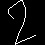

(60, 60) L


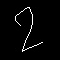

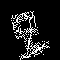

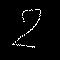

Identity


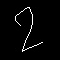

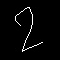

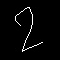

AutoContrast


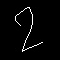

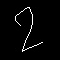

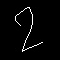

Equalize


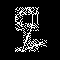

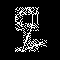

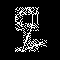

Rotate


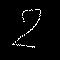

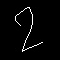

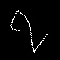

Solarize


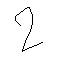

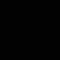

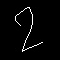

Color


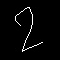

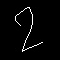

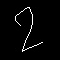

Contrast


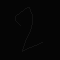

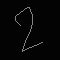

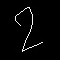

Brightness


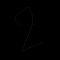

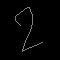

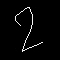

Sharpness


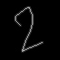

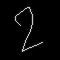

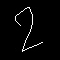

ShearX


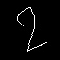

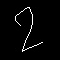

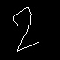

TranslateX


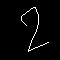

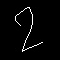

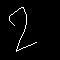

TranslateY


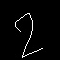

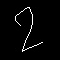

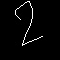

Posterize


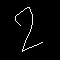

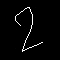

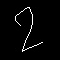

ShearY


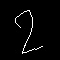

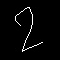

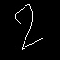

7/1/7-2 = -1.0


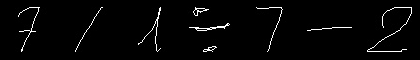

In [31]:
img = Image.open(symbol_images_dir + '2/2_849.jpg').convert('L')
img = ImageOps.invert(img)
display(img)
img = pad_image(img, desired_size)
print(img.size, img.mode)
display(img)
display(img_transform(img))
display(augment.apply_augment(img, 'Rotate', 0))
for aug_name in augment.augment_dict:
    print(aug_name)
    display(augment.apply_augment(img, aug_name, 0))
    display(augment.apply_augment(img, aug_name, 0.5))
    display(augment.apply_augment(img, aug_name, 1))

expr = '7/1/7-2'
img_paths = generate_img_paths(expr, sym_set=sym_set)
img = render_img(img_paths)
print(expr,'=', eval(expr))
display(img)